In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from data_processing import *

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna

import numpy as np
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### Load data
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:15<03:38, 15.64s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:24<02:28, 11.45s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:31<01:55,  9.64s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:39<01:38,  8.99s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:44<01:16,  7.61s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:49<01:01,  6.78s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:52<00:42,  5.27s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:54<00:30,  4.42s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [01:03<00:35,  5.86s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:11<00:32,  6.53s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:19<00:28,  7.02s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:28<00:22,  7.61s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:34<00:13,  6.97s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:42<00:07,  7.21s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:47<00:00,  7.18s/cell]


In [6]:
train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1,parts = 5)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)

Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 48609 rows (split into 65 parts)
Validation set: 4561 rows from 1 cells
Test set: 4602 rows from 1 cells


In [ ]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")

In [29]:
class SequenceDataset(Dataset):
    def __init__(self, df, seed_len=72, pred_len=5):
        self.seed_len = seed_len
        self.pred_len = pred_len
        
        # 分离特征和目标
        self.covariates = df[['Current[A]', 'Voltage[V]', 'Temperature[°C]']].values
        self.soh = df['SOH_ZHU'].values

    def __len__(self):
        return len(self.covariates) - (self.seed_len + self.pred_len)

    def __getitem__(self, idx):
        # 协变量序列
        x_covariates = self.covariates[idx:idx + self.seed_len]
        # SOH历史序列
        x_soh = self.soh[idx:idx + self.seed_len]
        # 目标SOH序列
        y_seq = self.soh[idx + self.seed_len:idx + self.seed_len + self.pred_len]

        return {
            'covariates': torch.tensor(x_covariates, dtype=torch.float32),
            'soh_history': torch.tensor(x_soh, dtype=torch.float32),
            'target': torch.tensor(y_seq, dtype=torch.float32)
        }

# 创建数据加载器
seq_length = 72
pred_len = 5
batch_size = 32

train_dataset = SequenceDataset(train_scaled, seed_len=seq_length, pred_len=pred_len)
val_dataset = SequenceDataset(val_scaled, seed_len=seq_length, pred_len=pred_len)
test_dataset = SequenceDataset(test_scaled, seed_len=seq_length, pred_len=pred_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [30]:
class LSTMSOH(nn.Module):
    def __init__(self, covariate_dim=3, hidden_dim=128, num_layers=3, dropout=0.3, pred_len=5):
        super(LSTMSOH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.pred_len = pred_len
        
        # 协变量编码器
        self.covariate_encoder = nn.LSTM(
            covariate_dim, hidden_dim, num_layers,
            batch_first=True, dropout=dropout,
            bidirectional=True
        )
        
        # SOH历史编码器
        self.soh_encoder = nn.LSTM(
            1, hidden_dim, num_layers,
            batch_first=True, dropout=dropout,
            bidirectional=True
        )
        
        # 注意力层
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # 预测器
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, pred_len)
        )
        
    def forward(self, covariates, soh_history=None, teacher_forcing_ratio=0.0):
        batch_size = covariates.size(0)
        
        # 编码协变量
        h0_cov = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=covariates.device)
        c0_cov = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=covariates.device)
        cov_out, _ = self.covariate_encoder(covariates, (h0_cov, c0_cov))
        
        if soh_history is not None and (teacher_forcing_ratio > 0 or self.training):
            # 编码SOH历史
            soh_history = soh_history.unsqueeze(-1)  # 添加特征维度
            h0_soh = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=covariates.device)
            c0_soh = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim, device=covariates.device)
            soh_out, _ = self.soh_encoder(soh_history, (h0_soh, c0_soh))
            
            # 结合两种特征
            combined_features = torch.cat([cov_out, soh_out], dim=-1)
        else:
            # 仅使用协变量特征
            combined_features = cov_out
            
        # 注意力机制
        attention_weights = self.attention(combined_features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context = torch.bmm(attention_weights.transpose(1, 2), combined_features)
        
        # 预测
        predictions = self.predictor(context.squeeze(1))
        
        return predictions


In [27]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_rmse': [], 'val_r2': []}
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # 计算teacher forcing比率（随着训练进行逐渐减小）
        teacher_forcing_ratio = max(0, 1 - (epoch / (num_epochs * 0.7)))
        
        # Training Loop
        model.train()
        train_losses = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            covariates = batch['covariates'].to(device)
            soh_history = batch['soh_history'].to(device)
            targets = batch['target'].to(device)
            
            # 使用teacher forcing进行预测
            predictions = model(
                covariates=covariates,
                soh_history=soh_history,
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            
            loss = criterion(predictions, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # Validation Loop
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                covariates = batch['covariates'].to(device)
                targets = batch['target'].to(device)
                
                # 验证时只使用协变量进行预测
                predictions = model(
                    covariates=covariates,
                    soh_history=None,  # 不使用SOH历史
                    teacher_forcing_ratio=0.0
                )
                
                val_loss = criterion(predictions, targets)
                val_losses.append(val_loss.item())
                
                all_preds.append(predictions.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        # 计算验证指标
        mean_val_loss = np.mean(val_losses)
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        r2 = r2_score(all_targets.flatten(), all_preds.flatten())
        
        history['val_loss'].append(mean_val_loss)
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"TF Ratio: {teacher_forcing_ratio:.2f} | "
              f"Train Loss: {mean_train_loss:.4e} | "
              f"Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | "
              f"R2: {r2:.4f}")
        
        # Early Stopping
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return history, best_model_state


In [31]:
model = LSTMSOH(
    covariate_dim=3,  # 电流、电压、温度
    hidden_dim=128,
    num_layers=3,
    dropout=0.3,
    pred_len=5
)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

# 训练模型
history, best_state = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    patience=10
)

# 保存最佳模型
torch.save(best_state, "best_model.pth")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2304x512 and 256x128)

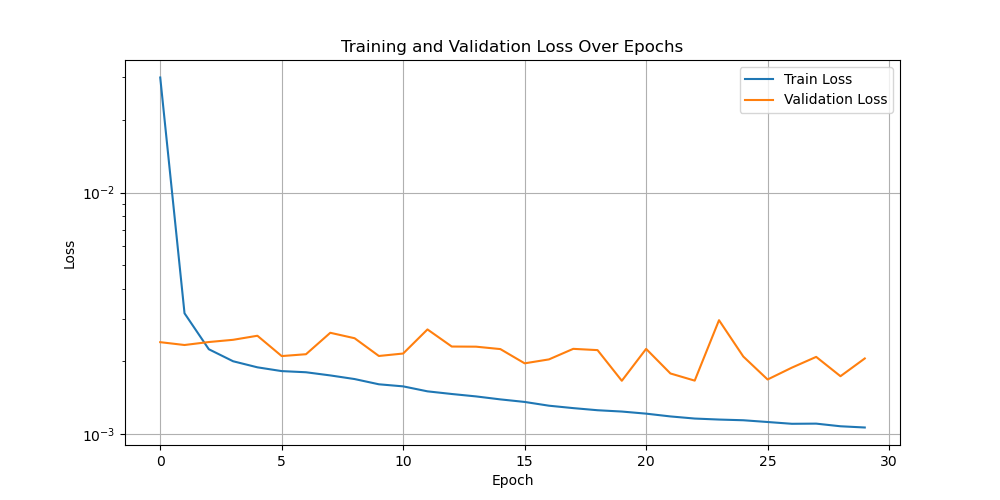

In [19]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.semilogy(history['train_loss'], label='Train Loss')
plt.semilogy(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example usage:
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step = 16)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float('dropout', 0.1,0.5)
    weight_decay= trial.suggest_float('weight_decay',1e-5,1e-1, log=True)
    
    seed_len = trial.suggest_int('seed_len', 12, 128)
    pred_len = trial.suggest_int('pred_len', 1, 20)
    batch_size = trial.suggest_int('batch_size', 16, 64, step = 8)
    
    train_dataset = SequenceDataset(train_scaled, seed_len=seed_len, pred_len=pred_len)
    val_dataset = SequenceDataset(val_scaled, seed_len=seed_len, pred_len=pred_len)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # Instantiate model with suggested hyperparameters
    model = LSTMSOH(input_dim=4, hidden_dim=hidden_size, num_layers=num_layers, dropout=dropout).type(torch.float32).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #L2 regularization
    history, _ = train_model(model, criterion, optimizer, train_loader, val_loader)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss

    # Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

In [ ]:
### predict_autoregressive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_model(model, test_loader, device):
    """
    Evaluate model performance on test set using multi-step prediction
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test set
        device: torch device
        
    Returns:
        dict: Dictionary containing evaluation metrics and predictions
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test = X_test.to(device)
            Y_test = Y_test.to(device)
            
            predictions = model(X_test)
            
            all_preds.append(predictions.cpu().numpy())
            all_targets.append(Y_test.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    metrics = {
        'r2': r2_score(all_targets, all_preds),
        'mae': mean_absolute_error(all_targets, all_preds),
        'rmse': np.sqrt(mean_squared_error(all_targets, all_preds)),
        'predictions': all_preds,
        'targets': all_targets
    }
    
    print(f"R2:{metrics['r2']:.5f} | MAE: {metrics['mae']:.5e}| RMSE:{metrics['rmse']:.5e}")
    
    return metrics

# Evaluate model
metrics = evaluate_model(model, test_loader, device)
all_preds = metrics['predictions'] 
all_targets = metrics['targets']



In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(all_targets[:, 0], label="Ground Truth SOH")
plt.plot(all_preds[:, 0], label="Predicted SOH")
plt.title("Autoregressive SOH-Estimation - Test ")
plt.xlabel("Samples")
plt.ylabel("SOH")
plt.legend()
plt.tight_layout()
plt.show()
